# Assignment 2: Stochastic & Spatial SIR Models

Lisa Pahladsingh & Sanjhana Bhusal

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

### 1.1 Implement Gillespies algorithm

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
np.random.seed(0)

In [2]:
# SIR with gillespies algorithm
def SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu):
    
    S = [S_0]
    I = [I_0]
    R = [R_0]
    t = [t_0]

# Create a while loop
    while t[-1] < t_end and (S[-1] + I[-1] >= 1):
        
        # Define constant N
        N = S[-1] + I[-1] + R[-1]
        rates = [mu * N, beta * I[-1] * S[-1]/N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]
        rates_sum = sum(rates)

        if I[-1] == 0:
            I[-1] = 1
        
        # Correct for error (dividing by 0)
        if rates_sum != 0:
            tau = np.random.exponential(scale = 1/rates_sum) 
        else:
            tau = 0  

        # Create random number
        rand_num = np.random.uniform(0, 1)

        # Birth
        if rand_num * rates_sum <= rates[0]:
            S.append(S[-1] + 1)
            I.append(I[-1])
            R.append(R[-1])

        # S -> I
        elif rand_num * rates_sum > rates[0] and rand_num * rates_sum <= sum(rates[:2]):
            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])

        # I -> R
        elif rand_num * rates_sum > sum(rates[:2]) and rand_num * rates_sum <= sum(rates[:3]):
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)

        # S -> death
        elif rand_num * rates_sum > sum(rates[:3]) and rand_num * rates_sum <= sum(rates[:4]): 
            S.append(S[-1] - 1)
            I.append(I[-1])
            R.append(R[-1])

        # I -> death
        elif rand_num * rates_sum > sum(rates[:4]) and rand_num * rates_sum <= sum(rates[:5]): 
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1])

        # R -> death
        elif rand_num * rates_sum > sum(rates[:5]) and rand_num * rates_sum <= sum(rates[:6]): 
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1] - 1)

        t.append(t[-1] + tau)
    
    return(t, S, I, R)

In [3]:
# Deterministic SIR model with demography
def SIR_deterministic(y, t, beta, gamma, mu):
    S = y[0]
    I = y[1]
    R = y[2]
    N = S + I + R
    
    dSdt = mu * N - beta * S * I/N - mu * S
    dIdt = beta * S * I/N - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    
    return [dSdt, dIdt, dRdt]

### Plotting Gillespies for a single run

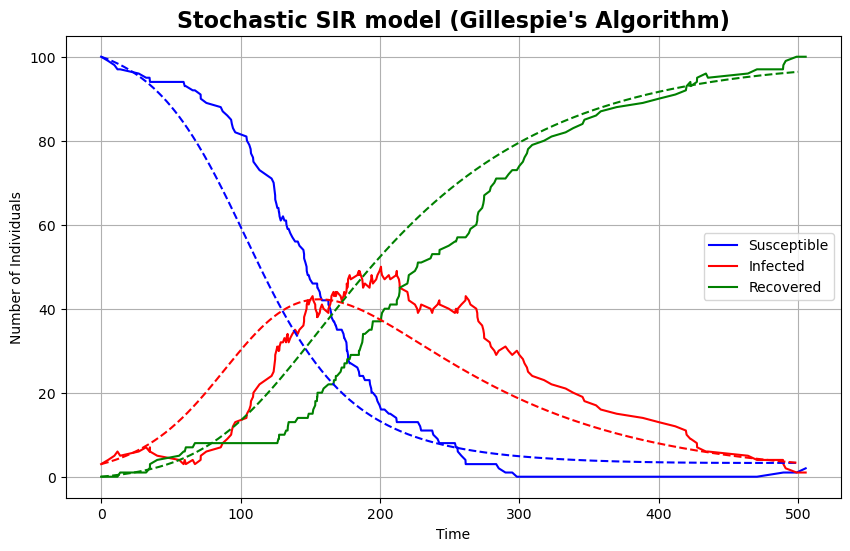

In [4]:
# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

y_0 = S_0, I_0, R_0

t_0 = 0
t_end = 500

t_deterministic = np.linspace(t_0, t_end, t_end+1)

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Extract S, I, R using GA
t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

# Extract S, I, R using determenistic model for comparison
sol_deterministic = odeint(SIR_deterministic, y_0, t_deterministic, args=(beta, gamma, mu))

# Plotting
plt.figure(figsize=(10,6))
plt.plot(t, S, 'b-', label='Susceptible')
plt.plot(t, I, 'r-', label='Infected')
plt.plot(t, R, 'g-', label='Recovered')
plt.plot(t_deterministic, sol_deterministic[:,0], 'b--')
plt.plot(t_deterministic, sol_deterministic[:,1], 'r--')
plt.plot(t_deterministic, sol_deterministic[:,2], 'g--')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title("Stochastic SIR model (Gillespie's Algorithm)", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### 1.2: Comparing variance and covariance between runs

### Variance

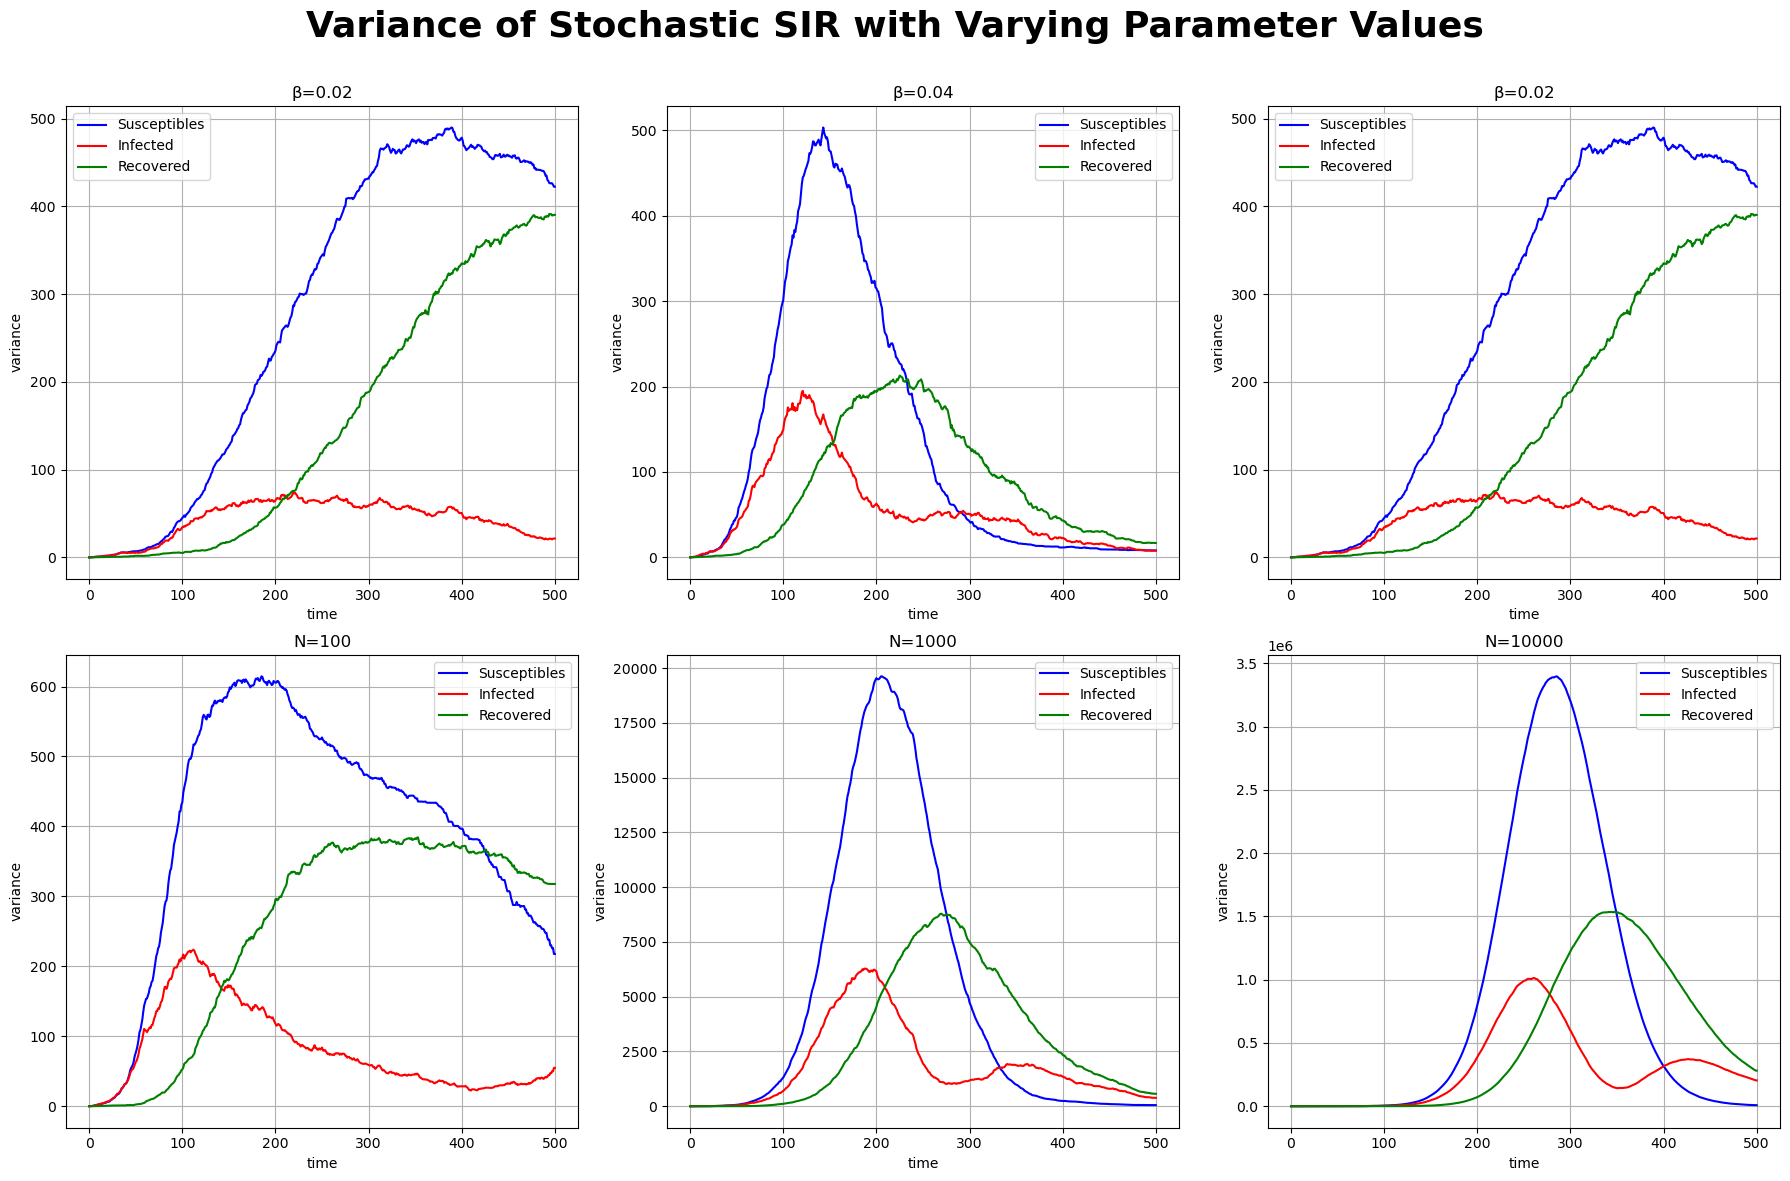

In [5]:
# Setting up function for variance
def GA_var(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run):
    
    # Setting range for binning of values
    t_data = np.linspace(0, t_end, t_end+1)
    
    # Setting data range
    S_df = pd.DataFrame(index=t_data)
    I_df = pd.DataFrame(index=t_data) 
    R_df = pd.DataFrame(index=t_data)
    
    for i_run in range(n_run):
        
        # Setting empty list of bins
        S_data = np.empty((t_end+1, 0)).tolist()
        I_data = np.empty((t_end+1, 0)).tolist() 
        R_data = np.empty((t_end+1, 0)).tolist()
        
        # Getting data
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

        for i, time in enumerate(t):
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

        for i in range(len(t_data)):
            if len(S_data[i]) == 0:
                S_data[i] = S_data[i-1]
                I_data[i] = I_data[i-1]
                R_data[i] = R_data[i-1]
            else:
                S_data[i] = sum(S_data[i])/len(S_data[i])
                I_data[i] = sum(I_data[i])/len(I_data[i])
                R_data[i] = sum(R_data[i])/len(R_data[i])
        
        # Adding to df
        S_df[str(i_run)] = S_data
        I_df[str(i_run)] = I_data
        R_df[str(i_run)] = R_data
    
    S_df_var = S_df.var(axis=1, ddof=0)
    I_df_var = I_df.var(axis=1, ddof=0)
    R_df_var = R_df.var(axis=1, ddof=0)
        
    return S_df_var, I_df_var, R_df_var

# Define values
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365
n_run = 40

def plot_variance(ax, S_0, I_0, R_0, beta, gamma, mu, title):
    np.random.seed(0)
    S_var, I_var, R_var = GA_var(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run)

    S_var.plot(ax=ax, label="Susceptibles", color='blue')
    I_var.plot(ax=ax, label="Infected", color='red')
    R_var.plot(ax=ax, label="Recovered", color='green')
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel("variance")
    ax.grid(True)
    ax.legend()

# Parameters
betas = [0.02, 0.04, 0.02]
Ns = [100, 1000, 10000]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Variance of Stochastic SIR with Varying Parameter Values", fontsize=26, fontweight='bold')

# Varying beta
for i, b in enumerate(betas):
    plot_variance(axs[0, i], S_0, I_0, R_0, b, gamma, mu, f"β={b}")

# Varying N
for i, n in enumerate(Ns):
    plot_variance(axs[1, i], n-3, I_0, R_0, beta, gamma, mu, f"N={n}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Covariance

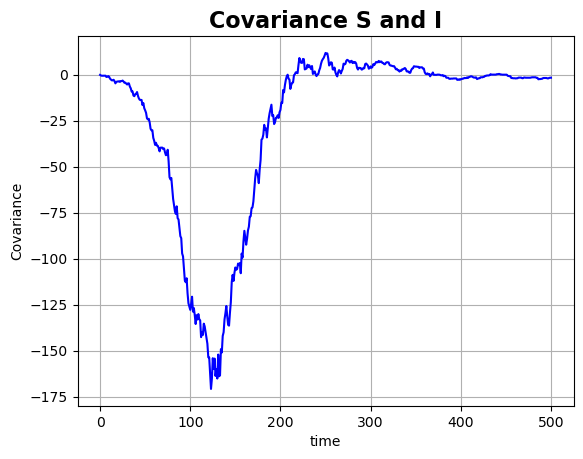

In [6]:
# Setting up function for variance
def GA_cov(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run):

    # Setting range for binning of values
    t_data = np.linspace(0, t_end, t_end+1)
    
    # Setting data range
    S_df = pd.DataFrame(index=t_data)
    I_df = pd.DataFrame(index=t_data) 
    R_df = pd.DataFrame(index=t_data)
    
    for i_run in range(n_run):
        
        # Setting empty list of bins
        S_data = np.empty((t_end+1, 0)).tolist()
        I_data = np.empty((t_end+1, 0)).tolist() 
        R_data = np.empty((t_end+1, 0)).tolist()
        
        # Getting data
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

        for i, time in enumerate(t):
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

        for i in range(len(t_data)):
            if len(S_data[i]) == 0:
                S_data[i] = S_data[i-1]
                I_data[i] = I_data[i-1]
                R_data[i] = R_data[i-1]
            else:
                S_data[i] = sum(S_data[i])/len(S_data[i])
                I_data[i] = sum(I_data[i])/len(I_data[i])
                R_data[i] = sum(R_data[i])/len(R_data[i])
        
        # Adding to df
        S_df[str(i_run)] = S_data
        I_df[str(i_run)] = I_data
        R_df[str(i_run)] = R_data
    
    S_df = S_df.transpose()
    I_df = I_df.transpose()
    cov = []
    
    for i in range(len(t_data)):
        SI_df = pd.DataFrame({
        'S': S_df[i],
        'I': I_df[i]
        })
        
        cov.append(SI_df.cov()['S']['I'])

    return cov

# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500
t_data = np.linspace(0, t_end, t_end+1)

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Average number of runs
n_run = 10

# Run simulations
np.random.seed(0)
cov = GA_cov(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run)

plt.plot(t_data, cov, 'b-')
plt.xlabel("time")
plt.ylabel("Covariance")
plt.title(f"Covariance S and I", fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

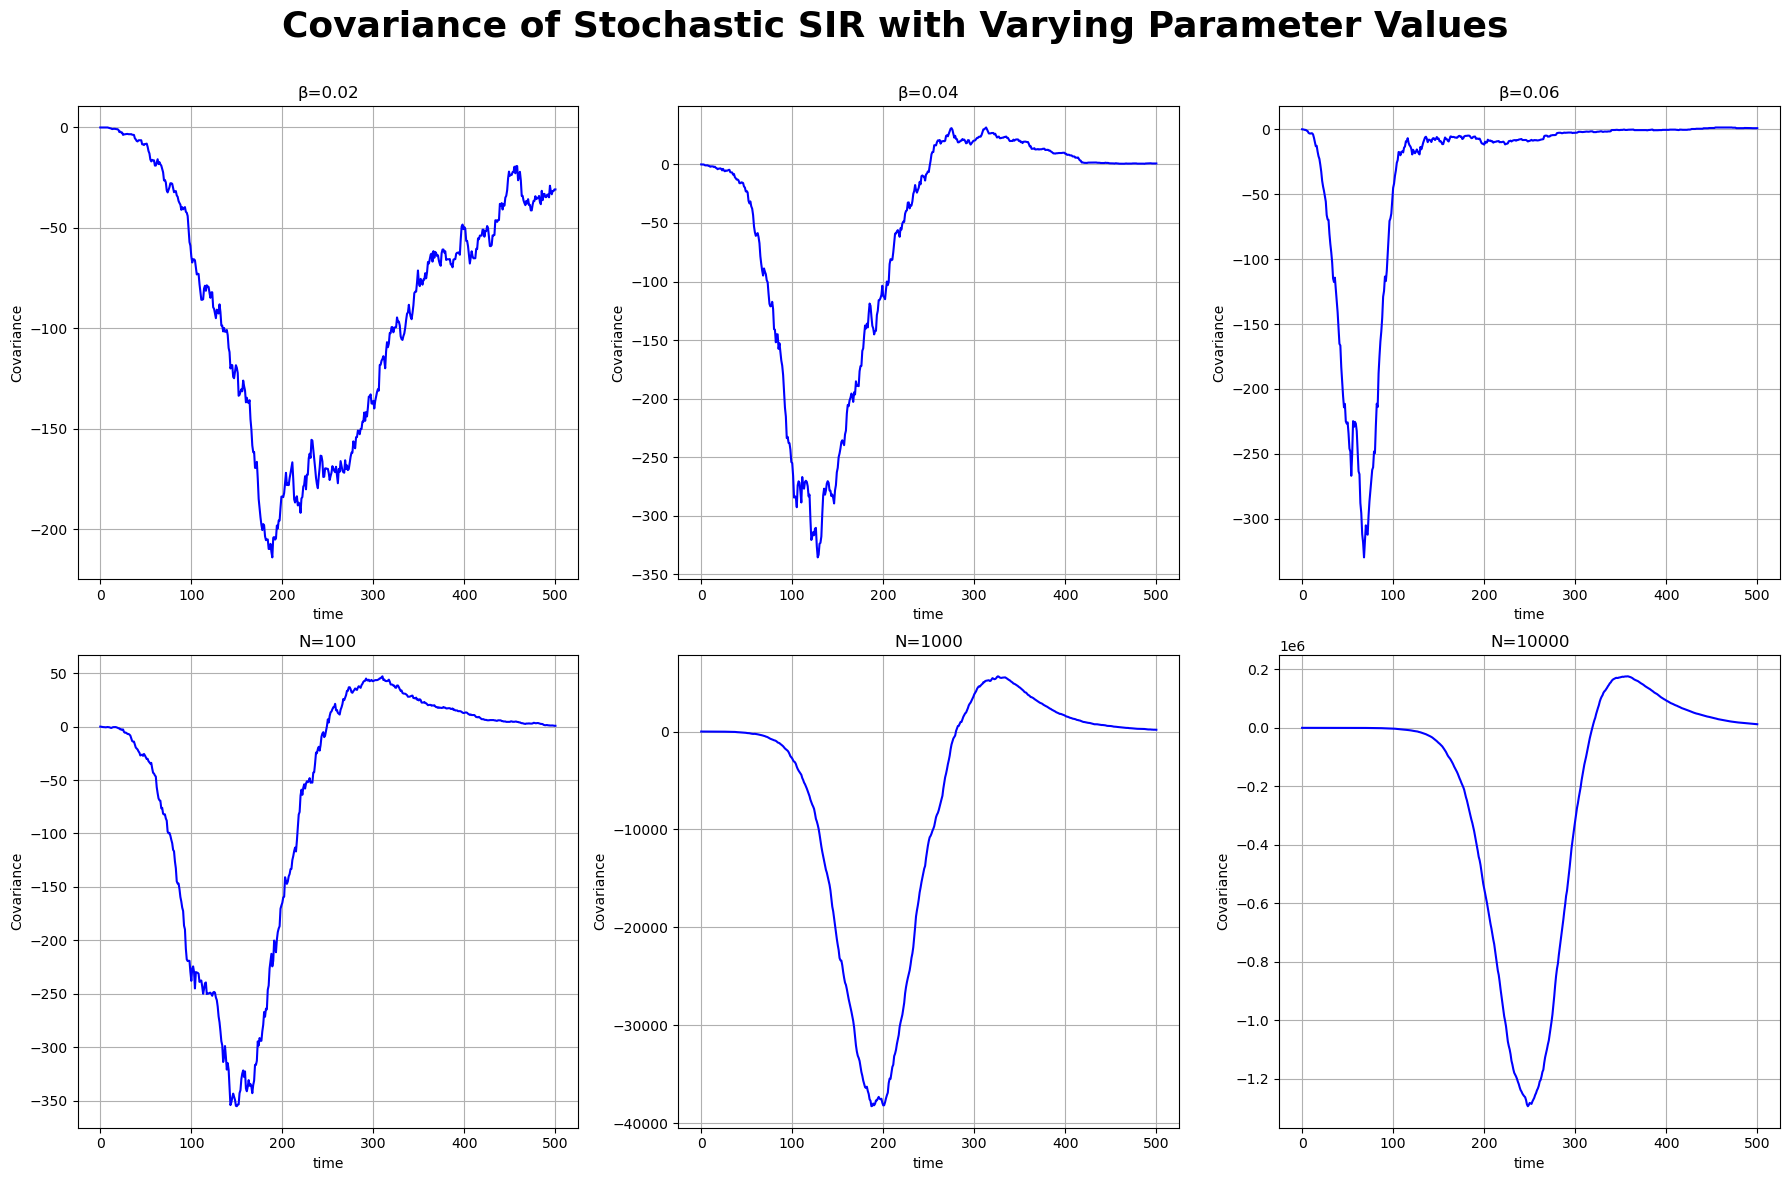

In [7]:
def plot_covariance(ax, S_0, I_0, R_0, beta, gamma, mu, title):
    cov = GA_cov(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run)
    ax.plot(t_data, cov, 'b-')
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel("Covariance")
    ax.grid(True)

# Define values
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500
t_data = np.linspace(0, t_end, t_end+1)

beta = 0.04
gamma = 0.01
mu = 0.02 / 365
n_run = 10

betas = [0.02, 0.04, 0.06]
Ns = [100, 1000, 10000]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Covariance of Stochastic SIR with Varying Parameter Values", fontsize=26, fontweight='bold')

# Varying beta
for i, b in enumerate(betas):
    plot_covariance(axs[0, i], S_0, I_0, R_0, b, gamma, mu, f"β={b}")

# Varying N
for i, n in enumerate(Ns):
    plot_covariance(axs[1, i], n-3, I_0, R_0, beta, gamma, mu, f"N={n}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

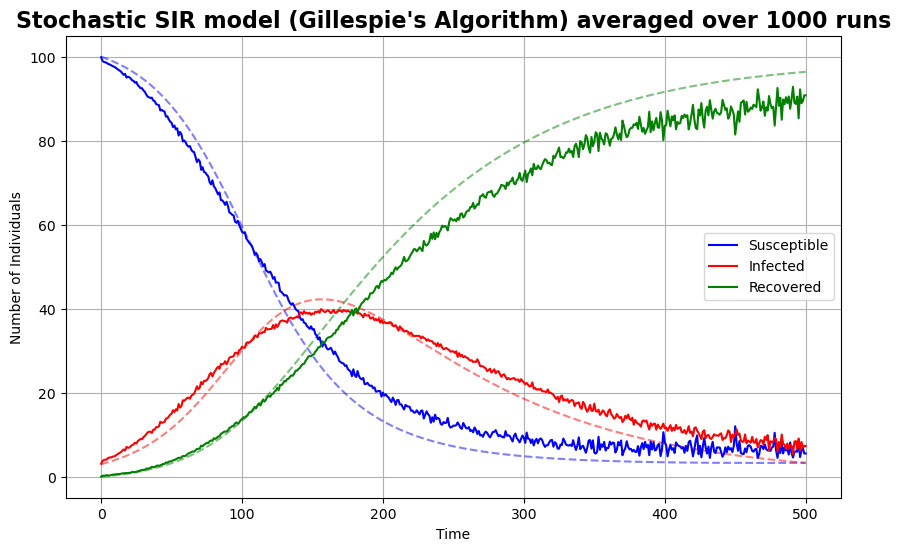

In [8]:
# Setting up function for averaging
def GA_average(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_sim):

    # Setting data range
    t_data = np.linspace(0, t_end, t_end+1)
    S_data = np.empty((t_end+1, 0)).tolist()
    I_data = np.empty((t_end+1, 0)).tolist() 
    R_data = np.empty((t_end+1, 0)).tolist()

    for _ in range(n_sim):
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)
        for i, time in enumerate(t):
            # Add S, I, R values from GA to predefined list
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

    # Average values
    for i in range(len(t_data)):
        if len(S_data[i]) == 0:
            S_data[i] = S_data[i-1]
            I_data[i] = I_data[i-1]
            R_data[i] = R_data[i-1]
        else:
            S_data[i] = sum(S_data[i])/len(S_data[i])
            I_data[i] = sum(I_data[i])/len(I_data[i])
            R_data[i] = sum(R_data[i])/len(R_data[i])
            
    return t_data, S_data, I_data, R_data

# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Average number of runs
n_sim = 1000

t_data, S_data, I_data, R_data = GA_average(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_sim)
sol_deterministic = odeint(SIR_deterministic, y_0, t_deterministic, args=(beta, gamma, mu))

# Plotting
plt.figure(figsize=(10,6))
plt.plot(t_deterministic, sol_deterministic[:,0], 'b--', alpha=0.5)
plt.plot(t_deterministic, sol_deterministic[:,1], 'r--', alpha=0.5)
plt.plot(t_deterministic, sol_deterministic[:,2], 'g--', alpha=0.5)
plt.plot(t_data, S_data, label='Susceptible', color='blue')
plt.plot(t_data, I_data, label='Infected', color='red')
plt.plot(t_data, R_data, label='Recovered', color='green')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title(f"Stochastic SIR model (Gillespie's Algorithm) averaged over {n_sim} runs", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### 1.3: Resonance and Increased Transients

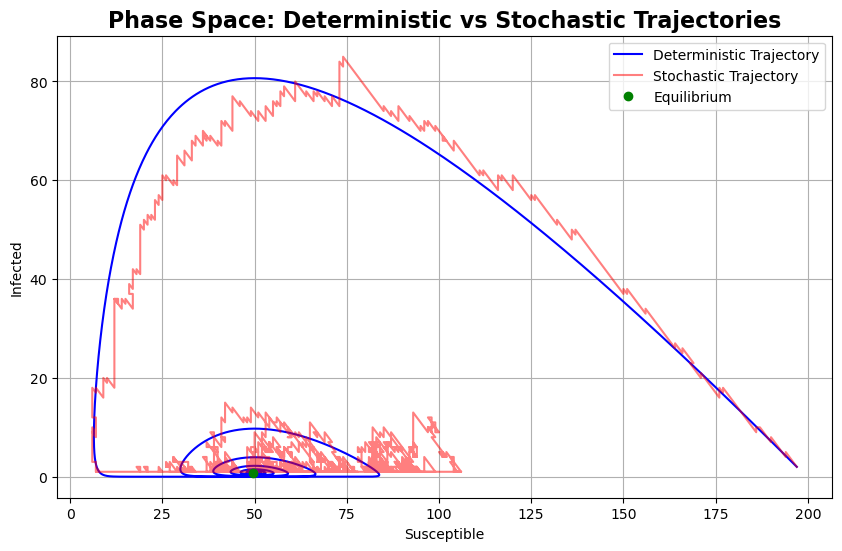

In [9]:
# Define initial value lists
N = 200
i_frac = 0.01
S_0 = N - I_0 - R_0
I_0 = int(i_frac * N)
R_0 = 0
y_0 = S_0, I_0, R_0

t_0 = 0
t_end = 40000
t_deterministic = np.linspace(t_0, t_end, t_end+1)


beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Extract S, I from deterministic model for phase space plot
sol_deterministic = odeint(SIR_deterministic, y_0, t_deterministic, args=(beta, gamma, mu))
S_det, I_det, _ = sol_deterministic.T

# Plot deterministic trajectory
plt.figure(figsize=(10, 6))
plt.plot(S_det, I_det, 'b-', label="Deterministic Trajectory")

# Plot stochastic trajectory
t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)
plt.plot(S, I, 'r-', alpha=0.5, label="Stochastic Trajectory")

# Equilibrium point
S_eq_numerical = S_det[-1]
I_eq_numerical = I_det[-1]
plt.plot(S_eq_numerical, I_eq_numerical, 'go', label="Equilibrium")

# Plotting
plt.xlabel("Susceptible")
plt.ylabel("Infected")
plt.title("Phase Space: Deterministic vs Stochastic Trajectories", fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()

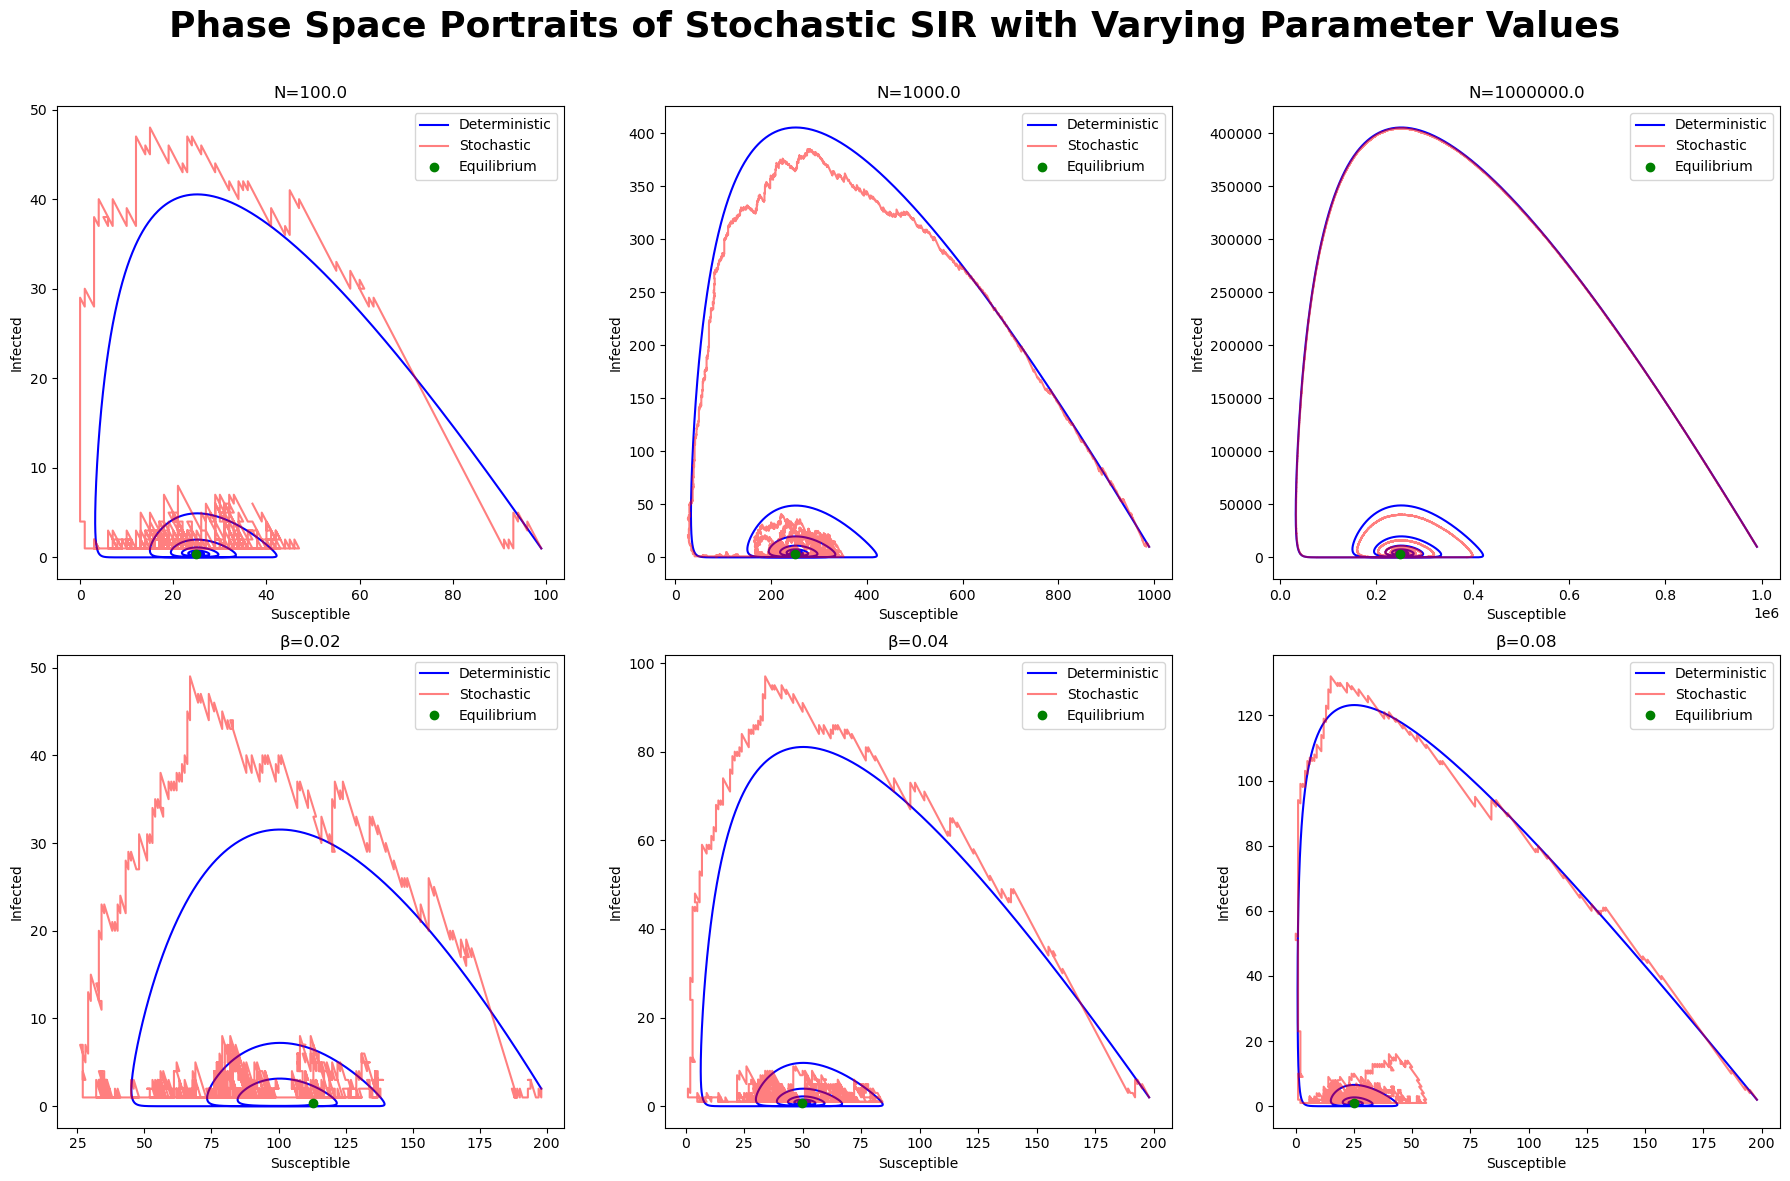

In [11]:
# Function for phase space
def phase_space(ax, N, beta, gamma, mu, title):
    i_frac = 0.01
    I_0 = int(i_frac * N)
    R_0 = 0
    S_0 = N - I_0 - R_0
    y_0 = S_0, I_0, R_0
    sol_deterministic = odeint(SIR_deterministic, y_0, t_deterministic, args=(beta, gamma, mu))
    S_det, I_det, _ = sol_deterministic.T
    
    t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)
    
    ax.plot(S_det, I_det, 'b-', label="Deterministic")
    ax.plot(S, I, 'r-', alpha=0.5, label="Stochastic")
    
    S_eq_numerical = S_det[-1]
    I_eq_numerical = I_det[-1]
    ax.plot(S_eq_numerical, I_eq_numerical, 'go', label="Equilibrium")
    
    ax.set_title(title)

    return


t_0 = 0
t_end = 40000
t_deterministic = np.linspace(t_0, t_end, t_end+1)

# Original parameter values
N = 200
beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Parameter ranges
Ns = [1e2, 1e3, 1e6]
betas = [0.02, 0.04, 0.08]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Phase Space Portraits of Stochastic SIR with Varying Parameter Values", fontsize=26, fontweight='bold')

# Varying N and beta and plotting
for i, n in enumerate(Ns):
    np.random.seed(0)
    phase_space(axs[0, i], n, beta, gamma, mu, f"N={(n)}")

for i, b in enumerate(betas):
    np.random.seed(0)
    phase_space(axs[1, i], N, b, gamma, mu, f"β={b}")

for ax in axs.flat:
    ax.set(xlabel="Susceptible", ylabel="Infected")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### 1.4: Extinction and Critical Community Size

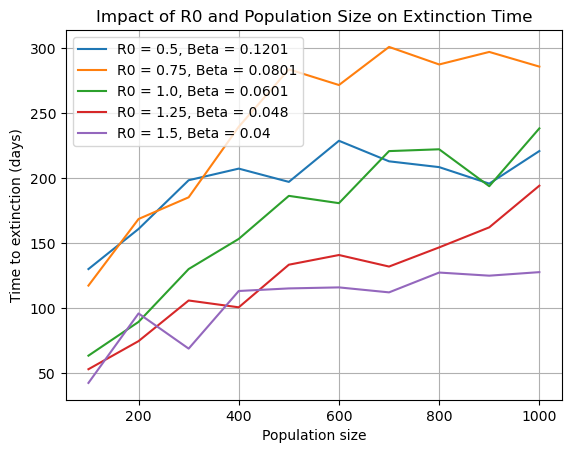

In [12]:
# SIR with GA adjusted for extinction
def SIR_GA_extinction(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu):
    S = [S_0]
    I = [I_0]
    R = [R_0]
    t = [t_0]
    
    t_extinct = False

    # Create a while loop
    while t[-1] < t_end and (S[-1] + I[-1] >= 1):
        
        N = S[-1] + I[-1] + R[-1]
        rates = [mu * N, beta * I[-1] * S[-1]/N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]
        rates_sum = sum(rates)

        if rates_sum != 0:
            tau = np.random.exponential(scale = 1/rates_sum) 

        else:
            tau = 0  

        rand_num = np.random.uniform(0, 1)
        
        if I[-1] == 0:
            t_extinct = t[-1]
            break 

        # Birth
        if rand_num * rates_sum <= rates[0]:
            S.append(S[-1] + 1)
            I.append(I[-1])
            R.append(R[-1])

        # S -> I
        elif rand_num * rates_sum > rates[0] and rand_num * rates_sum <= sum(rates[:2]):
            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])

        # I -> R
        elif rand_num * rates_sum > sum(rates[:2]) and rand_num * rates_sum <= sum(rates[:3]):
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)

        # S -> death
        elif rand_num * rates_sum > sum(rates[:3]) and rand_num * rates_sum <= sum(rates[:4]): 
            S.append(S[-1] - 1)
            I.append(I[-1])
            R.append(R[-1])

        # I -> death
        elif rand_num * rates_sum > sum(rates[:4]) and rand_num * rates_sum <= sum(rates[:5]): 
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1])

        # R -> death
        elif rand_num * rates_sum > sum(rates[:5]) and rand_num * rates_sum <= sum(rates[:6]): 
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1] - 1)

        t.append(t[-1] + tau)
        
    if not t_extinct:
        t_extinct = t_end
    
    return(t_extinct)

# R0 = (gamma + mu) / beta

# defining population and R0 values
n_pops = np.linspace(100, 1000, 10)
r_range = np.linspace(0.5, 1.5, 5)

# setting fraction of initial infected
init_infected = 0.03

# setting duration of simulation
t_0 = 0
t_end = 800

# setting simulation parameters
gamma = 0.06
mu = 0.02 / 365

# collecting data
for r0 in r_range:
    ext_data = []
    for n in n_pops:
    
        R_0 = 0
        I_0 = int(n * init_infected)
        S_0 = n - I_0 - R_0
        beta = (gamma + mu)/r0
    
        ave_ext = []
        for i in range(20):
            t_ext = SIR_GA_extinction(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)
            ave_ext.append(t_ext)
    
        ext_data.append(sum(ave_ext)/len(ave_ext))
    
    plt.plot(n_pops, ext_data, label=f"R0 = {str(r0)}, Beta = {round(beta, 4)}")
    
plt.legend()
plt.xlabel("Population size")
plt.ylabel("Time to extinction (days)")
plt.title("Impact of R0 and Population Size on Extinction Time")
plt.grid()
plt.show()


## Problem 2: Spatial Models - Networks

In [13]:
pip install ndlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:000:00:010:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
#import libraries
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend as BokehDiffusionTrend
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import ndlib.models.epidemics as ep


### 2.1 Exploring the implementation of SIR on one network

In [15]:
#Defining the random network 
number_nodes = 1000
prob_link = 0.1
graph = nx.erdos_renyi_graph(number_nodes, prob_link)

# selecting SIR model
SIRmodel = ep.SIRModel(graph)

In [16]:
# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
SIRmodel.set_initial_status(config)

In [17]:
# multiple Simulation
iterations = SIRmodel.iteration_bunch(200)
trends = SIRmodel.build_trends(iterations)

In [18]:
#visualizing the network itself
plt.figure(figsize=(12, 10))
positioning = nx.spring_layout(graph)  # Position of the nodes

edge_colour = 'black' 
edge_width = 0.01

nx.draw(graph, positioning, node_size=10, node_color='r', with_labels=False, edge_color=edge_colour, width=edge_width)
plt.title("Erdos-Renyi Network", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 1200x1000 with 0 Axes>

In [19]:
viz = DiffusionTrend(SIRmodel, trends)
p = viz.plot(width=400, height=400)
output_notebook()
show(p)

Loading BokehJS ...

In [20]:
#prevalence plot: variation of nodes across iterations
viz2 = DiffusionPrevalence(SIRmodel, trends)
p2 = viz2.plot(width=400, height=400)
output_notebook()
show(p2)

Loading BokehJS ...

In [21]:
vm = MultiPlot()
vm.add_plot(p)

# SIS
sis_model = ep.SISModel(graph)
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('lambda', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
sis_model.set_initial_status(config)
iterations = sis_model.iteration_bunch(200)
trends = sis_model.build_trends(iterations)

#creating a bokeh plot for SIS
viz = DiffusionTrend(sis_model, trends)
p3 = viz.plot(width=400, height=400)
vm_sis = MultiPlot()
vm_sis.add_plot(p3)

# SI
si_model = ep.SIModel(graph)
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter("fraction_infected", 0.05)
si_model.set_initial_status(config)
iterations = si_model.iteration_bunch(200)
trends = si_model.build_trends(iterations)

#bakeh plot for SI
viz_si = BokehDiffusionTrend(si_model, trends)
p4 = viz_si.plot(width=400, height=400)
vm_si = MultiPlot()
vm_si.add_plot(p4)

# Threshold
th_model = ep.ThresholdModel(graph)
config = mc.Configuration()

# Set individual node threshold
threshold = 0.40
for n in graph.nodes():
        config.add_node_configuration("threshold", n, threshold)

config.add_model_parameter("fraction_infected", 0.30)
th_model.set_initial_status(config)
iterations = th_model.iteration_bunch(60)
trends = th_model.build_trends(iterations)

#Bokeh plot for threshold 
viz = DiffusionTrend(th_model, trends)
p5 = viz.plot(width=400, height=400)
vm_threshold = MultiPlot()
vm_threshold.add_plot(p5)

# Plot all bokeh visualisations
m_sis = vm_sis.plot()
m_si = vm_si.plot()
m_threshold = vm_threshold.plot()

output_notebook()

# Show the plots
show(m_sis)
show(m_si)
show(m_threshold)

Loading BokehJS ...

### 2.2 Generating multiple models and analysis of the statistics


In [18]:
pip install altair==4.1.0

Note: you may need to restart the kernel to use updated packages.


#### 2.2.1 Generating  the networks and simulating SIR


In [17]:

# initializing parameters networks
number_nodes = 1000
prob_link = 0.1
k = 4

random_graph = nx.erdos_renyi_graph(number_nodes, prob_link)
barabasi_albert_graph = nx.scale_free_graph(number_nodes)
watts_strogatz_graph = nx.watts_strogatz_graph(number_nodes, k, 0.1)


In [18]:
def create_networks(network_type):
    if network_type == "random":
        return nx.erdos_renyi_graph(number_nodes, prob_link)
    elif network_type == "barabasi_albert":
        return nx.barabasi_albert_graph(number_nodes, 2)
    elif network_type == "watts_strogatz":
        return nx.watts_strogatz_graph(number_nodes, k, 0.1)
    else:
        raise ValueError("Invalid graph type")

#running the SIR on different networks
def run_SIR(network_type):
    # selecting SIR model
    SIRmodel = ep.SIRModel(create_networks(network_type))
    
    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', 0.04)
    config.add_model_parameter('gamma', 0.01)
    config.add_model_parameter("fraction_infected", 0.05)
    SIRmodel.set_initial_status(config)
    
    # multiple Simulation
    iterations = SIRmodel.iteration_bunch(200)
    trends = SIRmodel.build_trends(iterations)
    return trends

# Run simulations for each graph type
random_graph_trends = run_SIR("random")
barabasi_albert_graph_trends = run_SIR("barabasi_albert")
watts_strogatz_graph_trends = run_SIR("watts_strogatz")

In [23]:
from bokeh.plotting import show, output_notebook
from bokeh.models import Title, Label

#Visualizing the data
#Random network
viz = DiffusionTrend(SIRmodel, random_graph_trends)
p = viz.plot(width=400, height=400)
p.title = "SIR Model on Random Network"
p.xaxis.axis_label = "Time Steps"
p.yaxis.axis_label = "Fraction of population"
output_notebook()
show(p)

#barabasi_albert network
viz = DiffusionTrend(SIRmodel, barabasi_albert_graph_trends)
p = viz.plot(width=400, height=400)
p.title = "SIR Model on Barabasi-Albert"
p.xaxis.axis_label = "Time Steps"
p.yaxis.axis_label = "Fraction of population"
output_notebook()
show(p)

#watts_strogatz network 
viz = DiffusionTrend(SIRmodel, watts_strogatz_graph_trends)
p = viz.plot(width=400, height=400)
p.title = "SIR Model on Watts-Strogatz"
p.xaxis.axis_label = "Time Steps"
p.yaxis.axis_label = "Fraction of population"
output_notebook()
show(p)


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

#### 2.2.2 Analysing the statistics of the networks

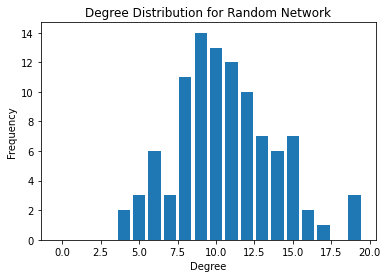

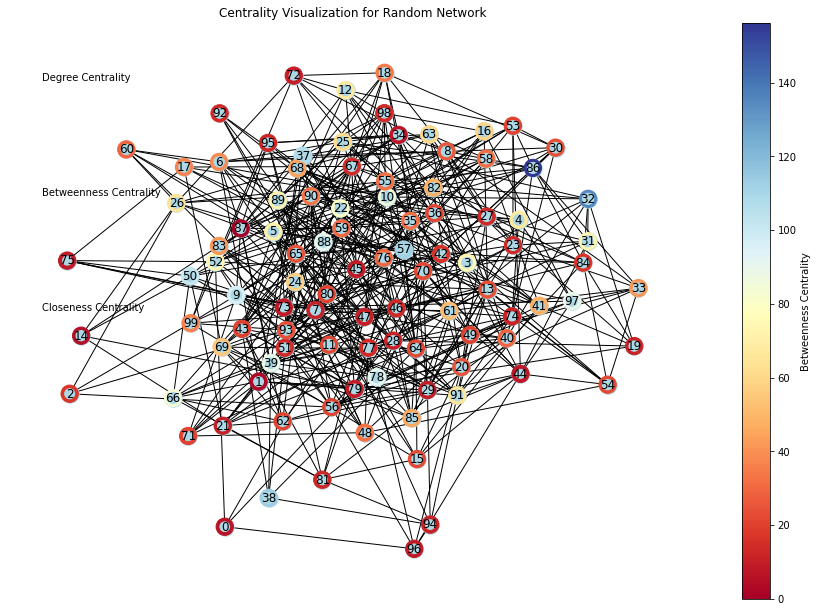

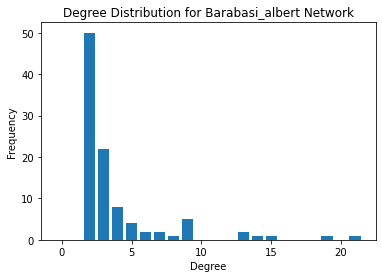

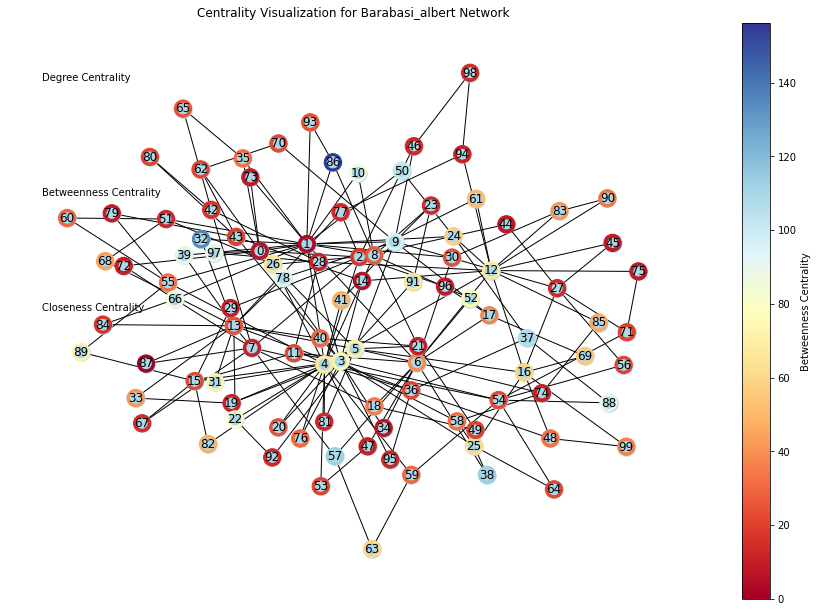

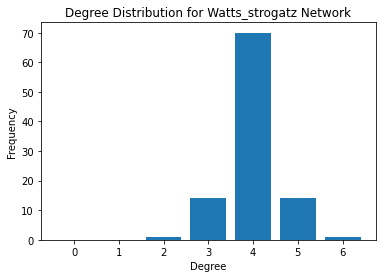

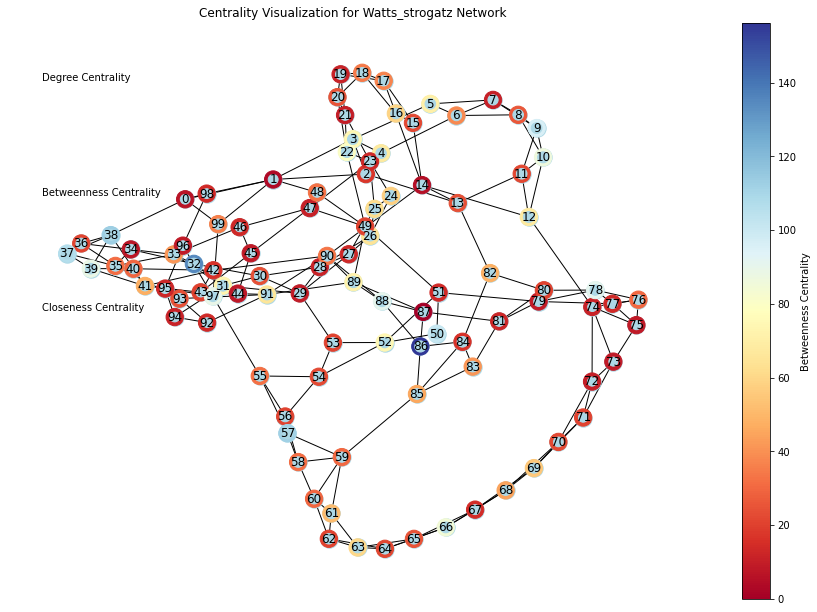

In [34]:
# a lit of the three networks
network_types = ["random", "barabasi_albert", "watts_strogatz"]

for network_type in network_types:
    if network_type == "random":
        G = nx.erdos_renyi_graph(100, 0.1)
    elif network_type == "barabasi_albert":
        G = nx.barabasi_albert_graph(100, 2)
    elif network_type == "watts_strogatz":
        G = nx.watts_strogatz_graph(100, 4, 0.1) 

    # Degree distribution
    degree_sequence = [d for n, d in G.degree()]
    degree_count = nx.degree_histogram(G)
    degrees = range(len(degree_count))

    plt.bar(degrees, degree_count)
    plt.title(f"Degree Distribution for {network_type.capitalize()} Network")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Calculate and visualize the different centrality measures
    degree = nx.degree_centrality(G)
    betweenness= nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)

    # initialize lay-out
    p = nx.spring_layout(G)

    # figure size
    plt.figure(figsize=(12, 8))

    # Visualization of the networks
    nx.draw(G, p, with_labels=True, node_color='lightblue', node_size=300)

    # Adjust nodes size proportional to degree centrality 
    node_size_degree = [500 * degree_centrality[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, p, node_size=node_size_degree, node_color='lightblue', cmap=plt.cm.RdYlBu)

    # Adjust Nodes colour proportional to betweenness centrality
    node_color_betweenness = list(betweenness_centrality.values())
    node_color_betweenness = [1000 * x for x in node_color_betweenness]
    nx.draw_networkx_nodes(G, p, node_size=300, node_color=node_color_betweenness, cmap=plt.cm.RdYlBu)

    # Adjust nodes size proportional to closeness centrality
    node_size_closeness = [500 * closeness_centrality[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, p, node_size=node_size_closeness, node_color='lightblue', cmap=plt.cm.RdYlBu)

    # Drawing of the node edges
    nx.draw_networkx_edges(G, p, alpha=0.5)

    # Add a color bar for betweenness centrality
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=plt.Normalize(vmin=min(node_color_betweenness), vmax=max(node_color_betweenness)))
    sm._A = []
    plt.colorbar(sm, label='Betweenness Centrality')

    # Add labels for each centrality measure
    plt.text(0.05, 0.9, 'Degree Centrality', transform=plt.gca().transAxes)
    plt.text(0.05, 0.7, 'Betweenness Centrality', transform=plt.gca().transAxes)
    plt.text(0.05, 0.5, 'Closeness Centrality', transform=plt.gca().transAxes)

    plt.title(f"Centrality Visualization for {network_type.capitalize()} Network")
    plt.axis('off')
    plt.show()